<a href="https://colab.research.google.com/github/erikrozi/acmlab/blob/ResNet/ResNet_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Drive Data

In [1]:
#this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in the Shared Google Drive
FOLDERNAME = 'Shared drives/Unsupervised'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/{}'.format(FOLDERNAME))

# !pwd
%cd /content/drive/$FOLDERNAME/
# %cp -vR * /content
# %cd /content
# !pwd
# !unzip imagery.zip -d imagery
# !unzip test_imagery.zip -d test_imagery
# %ls -lh

Mounted at /content/drive
/content/drive/Shared drives/Unsupervised


In [2]:

# Importing the standard ML libraries...
%load_ext autoreload
%autoreload 2

import pandas as pd                     # to process our data
import matplotlib.pyplot as plt         # graphing
import numpy as np                      # matrices

import torch
import torchvision                      # for MNIST dataset/working with images

import math

# take advantage of GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load Census Data

In [3]:
# Loads data with zip and aveincome
tax_returns_data = pd.read_csv("16zpallnoagi.csv")
cleaned_tax_data = pd.DataFrame(tax_returns_data, columns = ["ZIPCODE", "N1", "A02650"])
cleaned_tax_data = cleaned_tax_data[(cleaned_tax_data['ZIPCODE'] <= 97000) & (cleaned_tax_data['ZIPCODE'] >= 90000)] #remove zipcodes not in california
cleaned_tax_data.columns = ['zip', 'N1', 'A02650']
cleaned_tax_data['aveincome'] = ((cleaned_tax_data['A02650'] / cleaned_tax_data['N1']))#.astype(np.int32)

In [4]:
# Loads zips for Los Angeles
ziplation_data = pd.read_csv("ziplatlon.csv", sep = ";")
parsed_ziplation_data = ziplation_data[(ziplation_data['latitude'] <= 34.3) & (ziplation_data['latitude'] >= 33.5) & (ziplation_data['longitude'] >= -118.6) & (ziplation_data['longitude'] <= -117.6)]
parsed_ziplation_data = pd.merge(parsed_ziplation_data, cleaned_tax_data, how='left', on= 'zip')
parsed_ziplation_data = parsed_ziplation_data.dropna()

In [5]:
import util as util
import webmercator as webmercator

In [6]:
# creates image data and pulls latitude and longitude
z = 14
pos = np.empty([1980, 5])
for x in range(2794, 2839):
  for y in range(6528, 6572):
    curPos = (x - 2794) * (6572 - 6528) + (y - 6528)
    pos[curPos, 0] = x
    pos[curPos, 1] = y
    pos[curPos, 2] = webmercator.lat(y, z)
    pos[curPos, 3] = webmercator.lon(x, z)
    pos[curPos, 4] = util.getElevation(pos[curPos, 2], pos[curPos, 3])
image_pos_data = pd.DataFrame({'x': pos[:,0].astype(int), 'y': pos[:,1].astype(int), 'z': 14, 'latitude': pos[:,2], 'longitude': pos[:,3], 'elevation': pos[:,4]})
image_pos_data['img'] = "14_" + image_pos_data['x'].astype(str) + "_" + image_pos_data['y'].astype(str) + ".jpg"

Maps image to closest zip code

In [7]:
def calc_distance(lat1, long1, lat2, long2):
  xdist = long1 - long2
  ydist = lat1 - lat2
  return math.sqrt(xdist**2 + ydist**2)

In [8]:
np_ziplation = parsed_ziplation_data.to_numpy()
tile_zips = np.empty([image_pos_data.shape[0], 1])

np_ziplation.shape

#very inefficient lol
#for each image tile, loops through all the possible zipcodes, and chooses the one with the smallest distance
for i in range(image_pos_data.shape[0]):
  min_dist = 100000 #just made this an arbitrarily large number cuz iwas lazy
  for j in range(np_ziplation.shape[0]):
    zip_coords = np_ziplation[j][7].split(",") #splitting geopoint coords into latitude and longitude
    pt = image_pos_data['latitude'][i]
    cur_dist = calc_distance(pt, image_pos_data['longitude'][i], float(zip_coords[0]), float(zip_coords[1]))
    if cur_dist < min_dist:
      min_dist = cur_dist
      tile_zips[i] = np_ziplation[j][0]
image_pos_data['zipcode'] = tile_zips.astype(np.int32)

In [9]:
# Gets rid of ocean tiles
image_pos_data = image_pos_data[~(image_pos_data['elevation'] == 0)]

In [10]:
image_income_data = pd.DataFrame(image_pos_data, columns = ['img', 'zipcode'])
image_income_data.columns = ['img', 'zip']
image_income_data = pd.merge(image_income_data, cleaned_tax_data, how='left', on='zip')
image_income_data

img    zip     N1   A02650   aveincome
0     14_2794_6528.jpg  91311  18560  1694366   91.291272
1     14_2794_6529.jpg  91311  18560  1694366   91.291272
2     14_2794_6530.jpg  91311  18560  1694366   91.291272
3     14_2794_6531.jpg  91311  18560  1694366   91.291272
4     14_2794_6532.jpg  91311  18560  1694366   91.291272
...                ...    ...    ...      ...         ...
1452  14_2838_6567.jpg  92692  23430  2676168  114.219718
1453  14_2838_6568.jpg  92694  11460  2027274  176.900000
1454  14_2838_6569.jpg  92694  11460  2027274  176.900000
1455  14_2838_6570.jpg  92694  11460  2027274  176.900000
1456  14_2838_6571.jpg  92675  16750  2172841  129.721851

[1457 rows x 5 columns]

In [11]:
# Remove the unnecessary columns beside image url & average income
image_income_data = image_income_data[['img', 'aveincome', 'zip']]
image_income_data

img   aveincome    zip
0     14_2794_6528.jpg   91.291272  91311
1     14_2794_6529.jpg   91.291272  91311
2     14_2794_6530.jpg   91.291272  91311
3     14_2794_6531.jpg   91.291272  91311
4     14_2794_6532.jpg   91.291272  91311
...                ...         ...    ...
1452  14_2838_6567.jpg  114.219718  92692
1453  14_2838_6568.jpg  176.900000  92694
1454  14_2838_6569.jpg  176.900000  92694
1455  14_2838_6570.jpg  176.900000  92694
1456  14_2838_6571.jpg  129.721851  92675

[1457 rows x 3 columns]

In [12]:
image_income_data.to_csv('image_income_data.csv')

# Load Census Data

In [13]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class TileImageryDataset(Dataset):
  """Tile imagery dataset."""

  def __init__(self, csv_file, root_dir, transform=None):
    # Load into tensors
    self.annotations = pd.read_csv(csv_file)
    #self.annotations.iloc[:,2] = self.annotations.iloc[:, 2].astype('float32')
    self.root_dir = root_dir
    self.transform = transform

    # Perform data augmentation

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    image = Image.open(self.root_dir +  self.annotations.iloc[index,1])
    y_label = torch.tensor(self.annotations.iloc[index, 2])

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

  #def load_images():
  #  tensors = []
  #  for x in range(2794, 2839):
  #    for y in range(6528, 6572):
  #      image = Image.open(f"images/14_{x}_{y}.jpg").convert("RGB")
  #      # TODO change
  #      #jaden
  #      data = asarray(image) #convert to np array, could also do np.array(Image.open...)
  #      data = torch.from_numpy(data) #convert to tensor
  #      preprocess = transforms.Compose([
  #          transforms.Resize(256),
  #          transforms.CenterCrop(224),
  #          transforms.ToTensor(),
  #          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  #      ])
  #      input_tensor = preprocess(image)
  #      # tensory push thing?

In [14]:
from torch.utils.data import Dataset, DataLoader
batch_size = 32

transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(degrees = (90, 90)),
    transforms.ToTensor(),      
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                  
])

dataset = TileImageryDataset(csv_file = 'image_income_data.csv', root_dir = 'imagery/', transform = transformations)

train_set, test_set = torch.utils.data.random_split(dataset, [1200, 257])

trainloader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle=True)
testloader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle=False)



In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

import torch.nn as nn
import torch.nn.functional as F

# conv1 = nn.Conv2d(3, 36, 3)
# conv2 = nn.Conv2d(36, 72, 5)
# conv3 = nn.Conv2d(72, 90, 7)
# # conv1 = nn.Conv2d(3, 6, 5);
pool = nn.MaxPool2d(3, 3);
# # conv2 = nn.Conv2d(6, 16, 5);
# # conv3 = nn.Conv2d(16, 32, 5);
import torch.nn as nn
import torch.nn.functional as F


torch.Size([32, 3, 256, 256])
torch.Size([32])


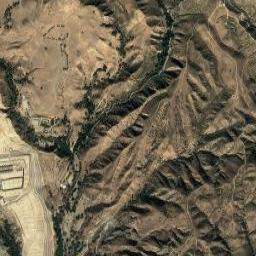

In [16]:
i = 0
image, label = dataset[i]
image = np.moveaxis(image.numpy(), 0, -1)
image = (image * 255).astype(np.uint8)
display(Image.fromarray(image).convert("RGB"))

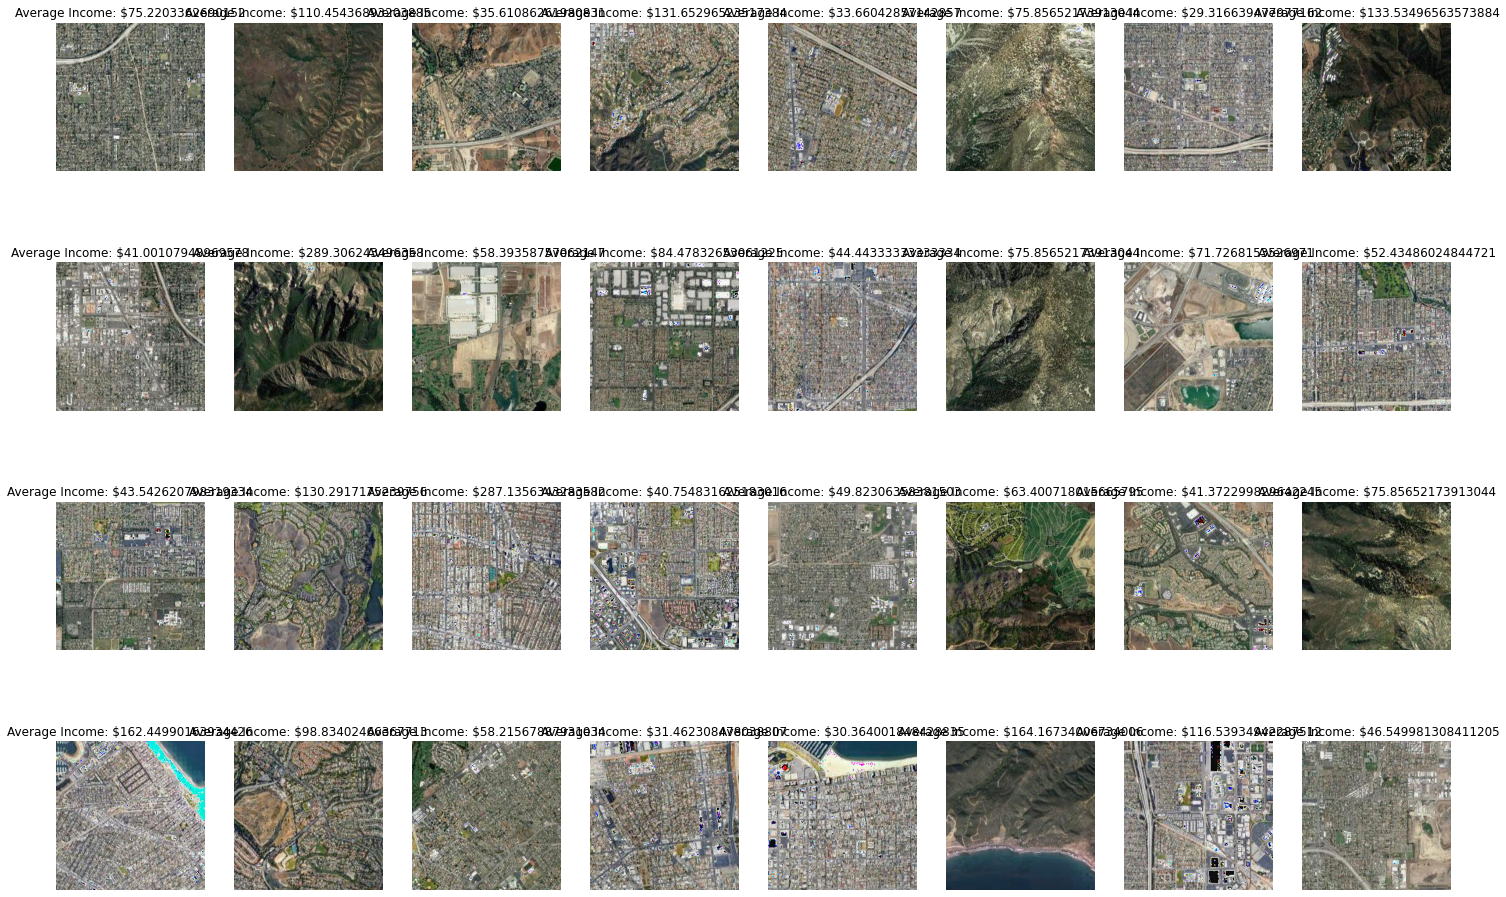

In [17]:
import torch.nn as nn
import torch.nn.functional as F

figure = plt.figure(figsize=(25, 10))
plt.subplots_adjust(top=1.4)
num_rows = 4
num_cols = 8
for idx in range(batch_size):
  plt.subplot(num_rows, num_cols, idx + 1) # subplot indices begin at 1, not 0
  plt.axis('off')
  plt.title('Average Income: ${}'.format(labels[idx]))
  image = np.moveaxis(images[idx].numpy(), 0, -1)
  image = (image * 275).astype(np.uint8)
  plt.imshow(image)


In [18]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [19]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)
conv5x5 = partial(Conv2dAuto, kernel_size=3, bias=False)
conv7x7 = partial(Conv2dAuto, kernel_size=3, bias=False)

In [ ]:
conv = conv3x3(in_channels=32, out_channels=64)
print(conv)
del conv

Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [ ]:
ResidualBlock(32, 64)

ResidualBlock(
  (blocks): Identity()
  (shortcut): Identity()
)

In [ ]:
dummy = torch.ones((1, 1, 1, 1))

block = ResidualBlock(1, 64)
block(dummy)

tensor([[[[2.]]]])

In [21]:
from collections import OrderedDict

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [ ]:
ResNetResidualBlock(32, 64)


ResNetResidualBlock(
  (blocks): Identity()
  (shortcut): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [22]:
from collections import OrderedDict
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [ ]:
conv_bn(3, 3, nn.Conv2d, kernel_size=3)

Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [23]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [ ]:
dummy = torch.ones((1, 32, 224, 224))

block = ResNetBasicBlock(32, 64)
block(dummy).shape
print(block)

ResNetBasicBlock(
  (blocks): Sequential(
    (0): Sequential(
      (conv): Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [25]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [26]:
dummy = torch.ones((1, 32, 10, 10))

block = ResNetBottleNeckBlock(32, 64)
block(dummy).shape
print(block)

ResNetBottleNeckBlock(
  (blocks): Sequential(
    (0): Sequential(
      (conv): Conv2dAuto(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Sequential(
      (conv): Conv2dAuto(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (conv): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [27]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [28]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256], depths=[2,2,2,2], #512 in sizes
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=depths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, depths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [29]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [30]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [31]:
cnn_model = ResNet(3, 1).to(device=device)
cnn_model.train()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.1) 

CLAMP = 200

epoch_losses = []

for epoch in range(100):
  epoch_loss = 0
  for batch_idx, (images, labels) in enumerate(trainloader):
    # Load the images and labels on the GPU
    images = images.to(device=device)
    #labels = labels.to(device=device, dtype=torch.float32)
    labels = labels.to(device=device)
    
    optimizer.zero_grad()                 # resets the information from last time
    pred_labels = cnn_model(images).squeeze()       # calculates the predictions
    #loss = criterion(pred_labels, labels)
    loss = criterion(pred_labels, torch.clamp(labels, 0, CLAMP).to(dtype=torch.float32)) # calculates the loss
    loss.backward()                       # gradient descent, part 1
    torch.nn.utils.clip_grad_norm(cnn_model.parameters(), 50) 
    optimizer.step()                      # gradient descent, part 2

    epoch_loss += loss.item() / labels.shape[0]
    if batch_idx % 10 == 0:
      print(f"Epoch {epoch}, batch {batch_idx}: {loss}")
  epoch_losses.append(epoch_loss)
  #writer.add_scalar('Loss/train', epoch_loss, epoch)
  print(f"Epoch {epoch}: {epoch_loss}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 0, batch 0: 83.37323760986328
Epoch 0, batch 10: 23.87909507751465
Epoch 0, batch 20: 33.913230895996094
Epoch 0, batch 30: 34.551021575927734
Epoch 0: 51.42300432920456
Epoch 1, batch 0: 32.02271270751953
Epoch 1, batch 10: 31.31253433227539
Epoch 1, batch 20: 31.717792510986328
Epoch 1, batch 30: 35.50137710571289
Epoch 1: 40.69062131643295
Epoch 2, batch 0: 29.937896728515625
Epoch 2, batch 10: 33.0224609375
Epoch 2, batch 20: 29.17054557800293
Epoch 2, batch 30: 25.085220336914062
Epoch 2: 42.09655660390854
Epoch 3, batch 0: 31.820674896240234
Epoch 3, batch 10: 40.455806732177734
Epoch 3, batch 20: 46.56364822387695
Epoch 3, batch 30: 37.485809326171875
Epoch 3: 43.43476611375809
Epoch 4, batch 0: 35.25122833251953
Epoch 4, batch 10: 26.98554801940918
Epoch 4, batch 20: 27.636436462402344
Epoch 4, batch 30: 37.63127136230469
Epoch 4: 39.923044323921204
Epoch 5, batch 0: 39.155372619628906
Epoch 5, batch 10: 28.938432693481445
Epoch 5, batch 20: 34.62044906616211
Epoch 5, bat

KeyboardInterrupt: ignored

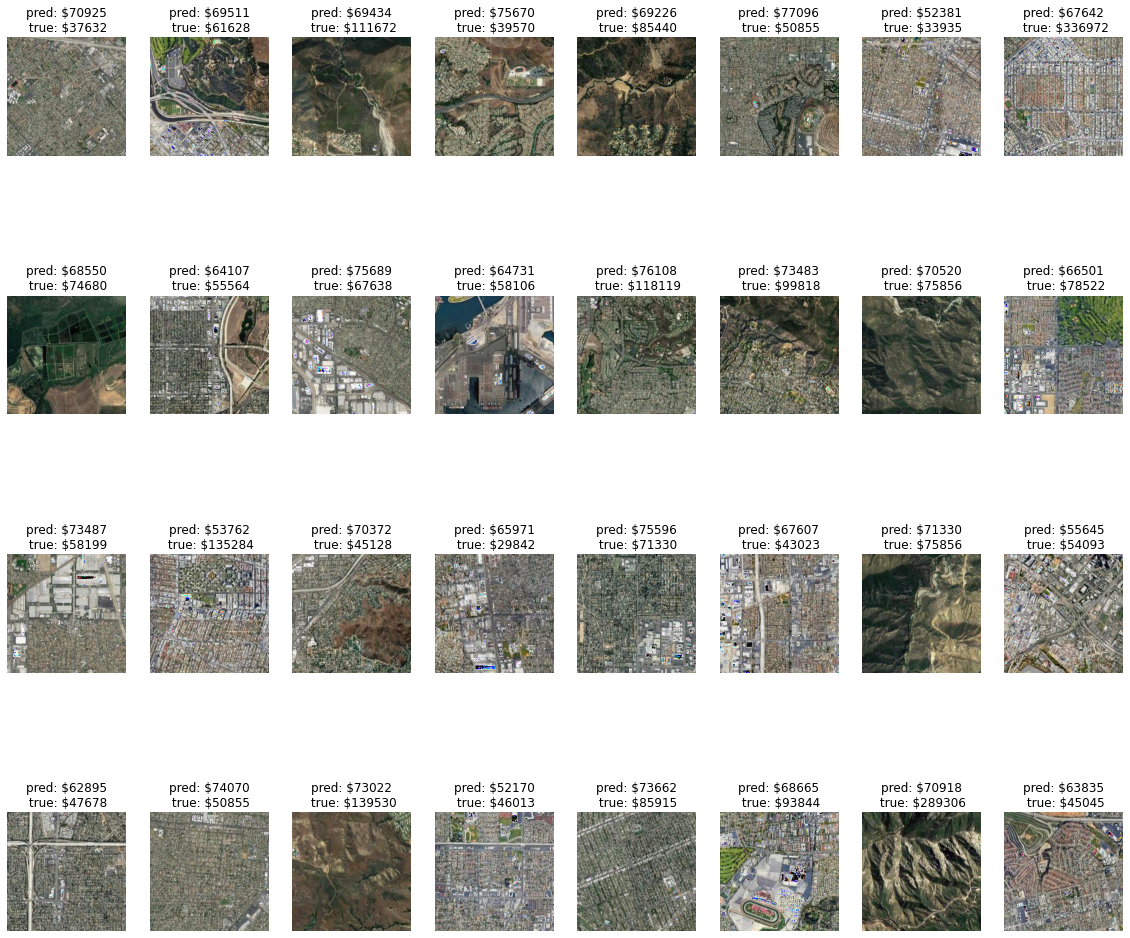

In [32]:
images, labels = next(iter(testloader))
cnn_model.eval()
outputs = cnn_model(images.to(device=device))
predicted = outputs.data.cpu().numpy().squeeze()

figure = plt.figure(figsize=(20, 10))
plt.subplots_adjust(top=1.5)
num_rows = 4
num_cols = 8
for idx in range(batch_size):
  plt.subplot(num_rows, num_cols, idx + 1) # subplot indices begin at 1, not 0
  plt.axis('off')
  plt.title(f"pred: ${(int)(predicted[idx] * 1000)}\n true: ${(int)(labels[idx] * 1000)}")
  image = np.moveaxis(images[idx].numpy(), 0, -1)
  image = (image * 275).astype(np.uint8)
  plt.imshow(image)